<a href="https://colab.research.google.com/github/amitdoda1983/EVA-Session-19/blob/master/Session_19_DCGAN_Guns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Team mates : Amit Doda & Upendra Roul

In [0]:
import os
#print(os.getcwd())
#print (os.listdir("/content/input_images_bw"))

#### Reading images as numpy arrays

In [0]:
import matplotlib.pyplot as plt

import sys

import numpy as np


folder = "/content/input_images_bw"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print (onlyfiles)
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
y_train = []
i=0


image_width = 64
image_height = 64

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(onlyfiles), image_height, image_width,channels),
                     dtype=np.float32)

i = 0
for _file in onlyfiles:
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)
    try:
      x = x.reshape((image_width, image_height,channels))
      # Normalize
      x = (x - 128.0) / 128.0
      dataset[i] = x
      i += 1
    except:
      pass
    if i % 100 == 0:
        print("%d images to array" % i)
print("All images to array!")

#### Number of inages used for training 364 , resized to 64x64x3

In [0]:
dataset.shape

(364, 64, 64, 3)

#### Sample image from training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


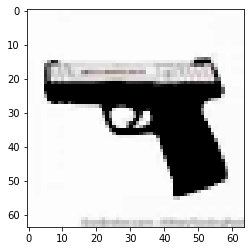

In [0]:
plt.imshow(dataset[15])

#### Build networks - Generator & Discriminator & Train the model

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = dataset
        # Rescale -1 to 1
        #X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        print (X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/My Drive/EVA/Session Assignments/GAN/guns_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=10000, batch_size=32, save_interval=100)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.055602, acc.: 43.75%] [G loss: 0.480906]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.676083, acc.: 67.19%] [G loss: 1.051965]
2 [D loss: 0.461059, acc.: 75.00%] [G loss: 1.468316]
3 [D loss: 0.395278, acc.: 81.25%] [G loss: 1.598698]
4 [D loss: 0.370669, acc.: 89.06%] [G loss: 1.603680]
5 [D loss: 0.481741, acc.: 79.69%] [G loss: 1.511743]
6 [D loss: 0.276629, acc.: 85.94%] [G loss: 1.641448]
7 [D loss: 0.317810, acc.: 85.94%] [G loss: 1.772175]
8 [D loss: 0.198426, acc.: 95.31%] [G loss: 1.276607]
9 [D loss: 0.229034, acc.: 95.31%] [G loss: 1.501617]
10 [D loss: 0.204613, acc.: 93.75%] [G loss: 1.602756]
11 [D loss: 0.400072, acc.: 82.81%] [G loss: 1.224108]
12 [D loss: 0.414211, acc.: 81.25%] [G loss: 1.755418]
13 [D loss: 0.956314, acc.: 46.88%] [G loss: 1.930144]
14 [D loss: 1.059327, acc.: 43.75%] [G loss: 1.829667]
15 [D loss: 0.666382, acc.: 65.62%] [G loss: 1.608584]
16 [D loss: 0.404645, acc.: 82.81%] [G loss: 1.762130]
17 [D loss: 0.349487, acc.: 78.12%] [G loss: 1.729802]
18 [D loss: 0.409777, acc.: 85.94%] [G loss: 2.508082]
19 [D loss: 0.32112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1801 [D loss: 0.206732, acc.: 92.19%] [G loss: 4.058609]
1802 [D loss: 0.169241, acc.: 96.88%] [G loss: 3.468200]
1803 [D loss: 0.165059, acc.: 96.88%] [G loss: 3.054862]
1804 [D loss: 0.218764, acc.: 96.88%] [G loss: 3.408861]
1805 [D loss: 0.160017, acc.: 98.44%] [G loss: 3.643651]
1806 [D loss: 0.093150, acc.: 100.00%] [G loss: 4.447579]
1807 [D loss: 0.495841, acc.: 71.88%] [G loss: 1.980221]
1808 [D loss: 0.310779, acc.: 87.50%] [G loss: 3.599406]
1809 [D loss: 0.146313, acc.: 95.31%] [G loss: 3.508863]
1810 [D loss: 0.466773, acc.: 76.56%] [G loss: 2.838799]
1811 [D loss: 0.429522, acc.: 78.12%] [G loss: 2.752269]
1812 [D loss: 0.133687, acc.: 96.88%] [G loss: 4.589147]
1813 [D loss: 0.871201, acc.: 51.56%] [G loss: 2.844037]
1814 [D loss: 0.160579, acc.: 92.19%] [G loss: 3.702591]
1815 [D loss: 0.224178, acc.: 93.75%] [G loss: 3.222328]
1816 [D loss: 0.245698, acc.: 87.50%] [G loss: 2.755445]
1817 [D loss: 0.282986, acc.: 89.06%] [G loss: 2.813124]
1818 [D loss: 0.575866, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1901 [D loss: 0.134116, acc.: 96.88%] [G loss: 3.901375]
1902 [D loss: 0.285314, acc.: 92.19%] [G loss: 4.029025]
1903 [D loss: 0.623857, acc.: 73.44%] [G loss: 2.915455]
1904 [D loss: 0.239401, acc.: 92.19%] [G loss: 2.929744]
1905 [D loss: 0.157083, acc.: 92.19%] [G loss: 4.254403]
1906 [D loss: 0.244263, acc.: 93.75%] [G loss: 3.574750]
1907 [D loss: 0.162845, acc.: 95.31%] [G loss: 3.211673]
1908 [D loss: 0.243230, acc.: 87.50%] [G loss: 3.167000]
1909 [D loss: 0.152462, acc.: 95.31%] [G loss: 3.494106]
1910 [D loss: 0.274669, acc.: 89.06%] [G loss: 2.951213]
1911 [D loss: 0.167515, acc.: 96.88%] [G loss: 3.460808]
1912 [D loss: 0.212247, acc.: 93.75%] [G loss: 3.570214]
1913 [D loss: 0.186933, acc.: 92.19%] [G loss: 3.144936]
1914 [D loss: 0.220055, acc.: 96.88%] [G loss: 3.077966]
1915 [D loss: 0.223239, acc.: 93.75%] [G loss: 3.211070]
1916 [D loss: 0.283260, acc.: 87.50%] [G loss: 2.836214]
1917 [D loss: 0.209716, acc.: 90.62%] [G loss: 2.925235]
1918 [D loss: 0.412917, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2001 [D loss: 0.129397, acc.: 100.00%] [G loss: 3.622570]
2002 [D loss: 0.427508, acc.: 84.38%] [G loss: 3.288310]
2003 [D loss: 0.356706, acc.: 84.38%] [G loss: 3.138107]
2004 [D loss: 0.148543, acc.: 93.75%] [G loss: 4.180466]
2005 [D loss: 0.112928, acc.: 98.44%] [G loss: 4.227510]
2006 [D loss: 0.728641, acc.: 64.06%] [G loss: 2.836371]
2007 [D loss: 0.128687, acc.: 96.88%] [G loss: 3.966829]
2008 [D loss: 0.238156, acc.: 89.06%] [G loss: 3.007508]
2009 [D loss: 0.157632, acc.: 92.19%] [G loss: 3.485873]
2010 [D loss: 0.110313, acc.: 98.44%] [G loss: 3.741710]
2011 [D loss: 0.241113, acc.: 90.62%] [G loss: 3.013247]
2012 [D loss: 0.292787, acc.: 89.06%] [G loss: 3.153664]
2013 [D loss: 0.373945, acc.: 79.69%] [G loss: 3.688522]
2014 [D loss: 0.501943, acc.: 71.88%] [G loss: 2.556606]
2015 [D loss: 0.322028, acc.: 76.56%] [G loss: 3.931314]
2016 [D loss: 0.068020, acc.: 98.44%] [G loss: 4.091885]
2017 [D loss: 0.144727, acc.: 96.88%] [G loss: 3.951169]
2018 [D loss: 0.209955, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2401 [D loss: 0.122171, acc.: 98.44%] [G loss: 3.840472]
2402 [D loss: 0.144405, acc.: 95.31%] [G loss: 3.688308]
2403 [D loss: 0.301037, acc.: 87.50%] [G loss: 4.354092]
2404 [D loss: 0.085969, acc.: 100.00%] [G loss: 4.512785]
2405 [D loss: 0.359262, acc.: 84.38%] [G loss: 2.503540]
2406 [D loss: 0.279937, acc.: 85.94%] [G loss: 3.439020]
2407 [D loss: 0.166197, acc.: 95.31%] [G loss: 4.499745]
2408 [D loss: 0.222352, acc.: 92.19%] [G loss: 4.195813]
2409 [D loss: 0.125256, acc.: 96.88%] [G loss: 3.672494]
2410 [D loss: 0.205765, acc.: 93.75%] [G loss: 4.076654]
2411 [D loss: 0.110218, acc.: 96.88%] [G loss: 4.092039]
2412 [D loss: 0.123579, acc.: 95.31%] [G loss: 4.208232]
2413 [D loss: 0.306723, acc.: 89.06%] [G loss: 2.915250]
2414 [D loss: 0.200630, acc.: 90.62%] [G loss: 3.764714]
2415 [D loss: 0.275870, acc.: 84.38%] [G loss: 3.366149]
2416 [D loss: 0.513387, acc.: 70.31%] [G loss: 2.988662]
2417 [D loss: 0.160583, acc.: 96.88%] [G loss: 2.630996]
2418 [D loss: 0.105383, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2501 [D loss: 0.161360, acc.: 95.31%] [G loss: 4.700784]
2502 [D loss: 0.115465, acc.: 96.88%] [G loss: 3.681730]
2503 [D loss: 0.086466, acc.: 100.00%] [G loss: 3.990673]
2504 [D loss: 0.052323, acc.: 100.00%] [G loss: 4.515728]
2505 [D loss: 0.099335, acc.: 100.00%] [G loss: 3.354364]
2506 [D loss: 0.134229, acc.: 95.31%] [G loss: 4.014673]
2507 [D loss: 0.091747, acc.: 96.88%] [G loss: 4.846872]
2508 [D loss: 0.078841, acc.: 98.44%] [G loss: 3.571958]
2509 [D loss: 0.065727, acc.: 98.44%] [G loss: 3.925232]
2510 [D loss: 0.406418, acc.: 81.25%] [G loss: 2.917766]
2511 [D loss: 0.225585, acc.: 92.19%] [G loss: 4.120407]
2512 [D loss: 0.071133, acc.: 96.88%] [G loss: 4.628741]
2513 [D loss: 0.073886, acc.: 100.00%] [G loss: 5.116862]
2514 [D loss: 0.080349, acc.: 98.44%] [G loss: 4.185771]
2515 [D loss: 0.188820, acc.: 90.62%] [G loss: 4.412421]
2516 [D loss: 0.182522, acc.: 96.88%] [G loss: 3.750843]
2517 [D loss: 0.386962, acc.: 78.12%] [G loss: 2.461987]
2518 [D loss: 0.380781, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2701 [D loss: 0.359578, acc.: 81.25%] [G loss: 2.630764]
2702 [D loss: 0.258910, acc.: 89.06%] [G loss: 3.867639]
2703 [D loss: 0.113835, acc.: 95.31%] [G loss: 4.623199]
2704 [D loss: 0.162143, acc.: 96.88%] [G loss: 4.627340]
2705 [D loss: 0.037152, acc.: 100.00%] [G loss: 5.261028]
2706 [D loss: 0.466119, acc.: 78.12%] [G loss: 3.214212]
2707 [D loss: 0.180314, acc.: 95.31%] [G loss: 4.366051]
2708 [D loss: 0.082061, acc.: 98.44%] [G loss: 3.939447]
2709 [D loss: 0.064442, acc.: 100.00%] [G loss: 5.484745]
2710 [D loss: 0.039911, acc.: 100.00%] [G loss: 4.702972]
2711 [D loss: 0.277536, acc.: 84.38%] [G loss: 3.277361]
2712 [D loss: 0.346036, acc.: 84.38%] [G loss: 4.354218]
2713 [D loss: 0.086484, acc.: 98.44%] [G loss: 5.154062]
2714 [D loss: 0.069075, acc.: 98.44%] [G loss: 4.769566]
2715 [D loss: 0.517893, acc.: 76.56%] [G loss: 3.732090]
2716 [D loss: 0.141921, acc.: 95.31%] [G loss: 2.695996]
2717 [D loss: 0.129801, acc.: 98.44%] [G loss: 3.988795]
2718 [D loss: 0.222111, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2801 [D loss: 0.070188, acc.: 96.88%] [G loss: 5.107600]
2802 [D loss: 0.060808, acc.: 98.44%] [G loss: 5.248521]
2803 [D loss: 0.385920, acc.: 78.12%] [G loss: 3.225953]
2804 [D loss: 0.297895, acc.: 87.50%] [G loss: 4.192679]
2805 [D loss: 0.040274, acc.: 100.00%] [G loss: 5.272552]
2806 [D loss: 0.283846, acc.: 85.94%] [G loss: 3.613917]
2807 [D loss: 0.330996, acc.: 84.38%] [G loss: 3.863204]
2808 [D loss: 0.255156, acc.: 87.50%] [G loss: 3.669280]
2809 [D loss: 0.090848, acc.: 100.00%] [G loss: 3.148036]
2810 [D loss: 0.134806, acc.: 95.31%] [G loss: 3.373690]
2811 [D loss: 0.075963, acc.: 98.44%] [G loss: 4.317700]
2812 [D loss: 0.153882, acc.: 93.75%] [G loss: 4.444186]
2813 [D loss: 0.354354, acc.: 85.94%] [G loss: 2.925613]
2814 [D loss: 0.185908, acc.: 93.75%] [G loss: 3.381490]
2815 [D loss: 0.060377, acc.: 98.44%] [G loss: 4.865050]
2816 [D loss: 0.215525, acc.: 93.75%] [G loss: 3.088907]
2817 [D loss: 0.232073, acc.: 90.62%] [G loss: 4.389033]
2818 [D loss: 0.067276, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2901 [D loss: 0.269405, acc.: 90.62%] [G loss: 4.818316]
2902 [D loss: 0.073781, acc.: 100.00%] [G loss: 4.082737]
2903 [D loss: 0.325923, acc.: 90.62%] [G loss: 3.724538]
2904 [D loss: 0.185412, acc.: 92.19%] [G loss: 3.590961]
2905 [D loss: 0.097746, acc.: 96.88%] [G loss: 3.755149]
2906 [D loss: 0.125602, acc.: 96.88%] [G loss: 4.593019]
2907 [D loss: 0.150092, acc.: 95.31%] [G loss: 4.126152]
2908 [D loss: 0.283043, acc.: 89.06%] [G loss: 3.232158]
2909 [D loss: 0.117099, acc.: 96.88%] [G loss: 3.661771]
2910 [D loss: 0.121328, acc.: 98.44%] [G loss: 3.917184]
2911 [D loss: 0.110599, acc.: 95.31%] [G loss: 4.463924]
2912 [D loss: 0.239519, acc.: 90.62%] [G loss: 3.768223]
2913 [D loss: 0.115336, acc.: 96.88%] [G loss: 4.078060]
2914 [D loss: 0.527189, acc.: 71.88%] [G loss: 3.533872]
2915 [D loss: 0.175772, acc.: 93.75%] [G loss: 5.161504]
2916 [D loss: 0.296684, acc.: 84.38%] [G loss: 3.165412]
2917 [D loss: 0.291833, acc.: 87.50%] [G loss: 3.237707]
2918 [D loss: 0.054459, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3001 [D loss: 0.239298, acc.: 89.06%] [G loss: 3.891179]
3002 [D loss: 0.023694, acc.: 100.00%] [G loss: 5.481969]
3003 [D loss: 0.180737, acc.: 95.31%] [G loss: 3.381263]
3004 [D loss: 0.098312, acc.: 98.44%] [G loss: 5.443619]
3005 [D loss: 0.175231, acc.: 96.88%] [G loss: 4.715653]
3006 [D loss: 0.310609, acc.: 89.06%] [G loss: 3.912412]
3007 [D loss: 0.096874, acc.: 100.00%] [G loss: 3.983782]
3008 [D loss: 0.110703, acc.: 96.88%] [G loss: 4.551799]
3009 [D loss: 0.207209, acc.: 89.06%] [G loss: 4.371262]
3010 [D loss: 0.118272, acc.: 95.31%] [G loss: 4.946569]
3011 [D loss: 0.031844, acc.: 100.00%] [G loss: 4.710840]
3012 [D loss: 0.100628, acc.: 96.88%] [G loss: 5.388766]
3013 [D loss: 0.071861, acc.: 98.44%] [G loss: 4.490699]
3014 [D loss: 0.214698, acc.: 95.31%] [G loss: 3.706307]
3015 [D loss: 0.289632, acc.: 84.38%] [G loss: 5.311425]
3016 [D loss: 0.055098, acc.: 100.00%] [G loss: 6.103995]
3017 [D loss: 0.782204, acc.: 65.62%] [G loss: 2.541546]
3018 [D loss: 0.288097, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3301 [D loss: 0.240619, acc.: 89.06%] [G loss: 3.985781]
3302 [D loss: 0.094552, acc.: 98.44%] [G loss: 4.620825]
3303 [D loss: 0.087785, acc.: 95.31%] [G loss: 3.628882]
3304 [D loss: 0.097543, acc.: 96.88%] [G loss: 4.226322]
3305 [D loss: 0.128155, acc.: 92.19%] [G loss: 3.763516]
3306 [D loss: 0.166737, acc.: 93.75%] [G loss: 4.194260]
3307 [D loss: 0.061103, acc.: 98.44%] [G loss: 4.666533]
3308 [D loss: 0.086804, acc.: 96.88%] [G loss: 4.931110]
3309 [D loss: 0.077830, acc.: 98.44%] [G loss: 3.852063]
3310 [D loss: 0.135336, acc.: 95.31%] [G loss: 5.293995]
3311 [D loss: 0.201271, acc.: 92.19%] [G loss: 3.686743]
3312 [D loss: 0.276879, acc.: 90.62%] [G loss: 2.767258]
3313 [D loss: 0.086206, acc.: 96.88%] [G loss: 4.337899]
3314 [D loss: 0.113511, acc.: 93.75%] [G loss: 4.965820]
3315 [D loss: 0.082874, acc.: 100.00%] [G loss: 5.139794]
3316 [D loss: 0.257868, acc.: 92.19%] [G loss: 5.356991]
3317 [D loss: 0.070916, acc.: 100.00%] [G loss: 5.121217]
3318 [D loss: 0.042222, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3401 [D loss: 0.058286, acc.: 96.88%] [G loss: 5.158264]
3402 [D loss: 0.177339, acc.: 92.19%] [G loss: 4.789469]
3403 [D loss: 0.182559, acc.: 96.88%] [G loss: 4.055487]
3404 [D loss: 0.035899, acc.: 100.00%] [G loss: 5.258729]
3405 [D loss: 0.051386, acc.: 98.44%] [G loss: 6.029623]
3406 [D loss: 0.027489, acc.: 100.00%] [G loss: 6.748517]
3407 [D loss: 0.036766, acc.: 100.00%] [G loss: 5.108833]
3408 [D loss: 0.069268, acc.: 100.00%] [G loss: 4.518052]
3409 [D loss: 0.113630, acc.: 96.88%] [G loss: 4.610134]
3410 [D loss: 0.287517, acc.: 89.06%] [G loss: 3.839514]
3411 [D loss: 0.089719, acc.: 95.31%] [G loss: 4.875760]
3412 [D loss: 0.242499, acc.: 92.19%] [G loss: 4.235478]
3413 [D loss: 0.171785, acc.: 96.88%] [G loss: 3.949312]
3414 [D loss: 0.147971, acc.: 96.88%] [G loss: 5.050289]
3415 [D loss: 0.233493, acc.: 87.50%] [G loss: 4.243571]
3416 [D loss: 0.087689, acc.: 96.88%] [G loss: 4.455925]
3417 [D loss: 0.200735, acc.: 90.62%] [G loss: 4.479697]
3418 [D loss: 0.091545, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3701 [D loss: 0.075386, acc.: 95.31%] [G loss: 5.337910]
3702 [D loss: 0.058955, acc.: 100.00%] [G loss: 4.254500]
3703 [D loss: 0.059344, acc.: 98.44%] [G loss: 5.463031]
3704 [D loss: 0.059113, acc.: 98.44%] [G loss: 5.917335]
3705 [D loss: 0.209235, acc.: 95.31%] [G loss: 3.660717]
3706 [D loss: 0.103998, acc.: 96.88%] [G loss: 4.599943]
3707 [D loss: 0.025188, acc.: 100.00%] [G loss: 5.525662]
3708 [D loss: 0.031654, acc.: 100.00%] [G loss: 5.418688]
3709 [D loss: 0.135799, acc.: 95.31%] [G loss: 5.201928]
3710 [D loss: 0.082687, acc.: 98.44%] [G loss: 4.913820]
3711 [D loss: 0.044725, acc.: 100.00%] [G loss: 5.521925]
3712 [D loss: 0.061391, acc.: 98.44%] [G loss: 4.600882]
3713 [D loss: 0.018799, acc.: 100.00%] [G loss: 5.387846]
3714 [D loss: 0.147982, acc.: 100.00%] [G loss: 5.028863]
3715 [D loss: 0.206608, acc.: 90.62%] [G loss: 5.125400]
3716 [D loss: 0.045421, acc.: 100.00%] [G loss: 6.092299]
3717 [D loss: 0.442171, acc.: 78.12%] [G loss: 3.580052]
3718 [D loss: 0.163821, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4101 [D loss: 0.126272, acc.: 95.31%] [G loss: 3.549782]
4102 [D loss: 0.059112, acc.: 98.44%] [G loss: 5.230268]
4103 [D loss: 0.076224, acc.: 96.88%] [G loss: 5.186686]
4104 [D loss: 0.160364, acc.: 95.31%] [G loss: 4.888362]
4105 [D loss: 0.057100, acc.: 100.00%] [G loss: 4.676188]
4106 [D loss: 0.088432, acc.: 98.44%] [G loss: 4.345313]
4107 [D loss: 0.095366, acc.: 98.44%] [G loss: 5.096499]
4108 [D loss: 0.024027, acc.: 100.00%] [G loss: 5.135409]
4109 [D loss: 0.049144, acc.: 98.44%] [G loss: 4.036370]
4110 [D loss: 0.049762, acc.: 98.44%] [G loss: 4.417763]
4111 [D loss: 0.079435, acc.: 98.44%] [G loss: 3.979628]
4112 [D loss: 0.056960, acc.: 100.00%] [G loss: 5.463629]
4113 [D loss: 0.117477, acc.: 93.75%] [G loss: 6.248803]
4114 [D loss: 0.029092, acc.: 98.44%] [G loss: 6.159928]
4115 [D loss: 0.026154, acc.: 100.00%] [G loss: 7.420249]
4116 [D loss: 0.080419, acc.: 96.88%] [G loss: 6.170713]
4117 [D loss: 0.083853, acc.: 98.44%] [G loss: 6.942667]
4118 [D loss: 0.049409, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4201 [D loss: 0.048294, acc.: 98.44%] [G loss: 6.661999]
4202 [D loss: 0.068380, acc.: 98.44%] [G loss: 6.281251]
4203 [D loss: 0.111586, acc.: 96.88%] [G loss: 6.809855]
4204 [D loss: 0.107559, acc.: 96.88%] [G loss: 6.483171]
4205 [D loss: 0.081888, acc.: 96.88%] [G loss: 4.221870]
4206 [D loss: 0.031759, acc.: 98.44%] [G loss: 5.803078]
4207 [D loss: 0.035809, acc.: 100.00%] [G loss: 4.132210]
4208 [D loss: 0.014701, acc.: 100.00%] [G loss: 5.460415]
4209 [D loss: 0.167043, acc.: 95.31%] [G loss: 3.834562]
4210 [D loss: 0.136205, acc.: 93.75%] [G loss: 5.273432]
4211 [D loss: 0.092987, acc.: 95.31%] [G loss: 6.728777]
4212 [D loss: 0.149999, acc.: 95.31%] [G loss: 5.701735]
4213 [D loss: 0.067359, acc.: 96.88%] [G loss: 5.343916]
4214 [D loss: 0.130478, acc.: 96.88%] [G loss: 4.850779]
4215 [D loss: 0.050342, acc.: 98.44%] [G loss: 5.578446]
4216 [D loss: 0.098936, acc.: 96.88%] [G loss: 5.222776]
4217 [D loss: 0.109108, acc.: 96.88%] [G loss: 5.490581]
4218 [D loss: 0.175882, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4301 [D loss: 0.084246, acc.: 98.44%] [G loss: 4.404868]
4302 [D loss: 0.098393, acc.: 96.88%] [G loss: 5.378027]
4303 [D loss: 0.028713, acc.: 100.00%] [G loss: 6.449869]
4304 [D loss: 0.177596, acc.: 95.31%] [G loss: 4.877298]
4305 [D loss: 0.095065, acc.: 96.88%] [G loss: 5.640592]
4306 [D loss: 0.180487, acc.: 92.19%] [G loss: 5.349593]
4307 [D loss: 0.021445, acc.: 100.00%] [G loss: 6.396564]
4308 [D loss: 0.029326, acc.: 100.00%] [G loss: 5.277461]
4309 [D loss: 0.033104, acc.: 100.00%] [G loss: 5.740055]
4310 [D loss: 0.035151, acc.: 98.44%] [G loss: 5.477483]
4311 [D loss: 0.143299, acc.: 95.31%] [G loss: 5.183004]
4312 [D loss: 0.063401, acc.: 98.44%] [G loss: 6.157358]
4313 [D loss: 0.166208, acc.: 95.31%] [G loss: 5.384178]
4314 [D loss: 0.074596, acc.: 98.44%] [G loss: 5.020899]
4315 [D loss: 0.037772, acc.: 100.00%] [G loss: 6.354325]
4316 [D loss: 0.147646, acc.: 96.88%] [G loss: 4.576685]
4317 [D loss: 0.030925, acc.: 100.00%] [G loss: 5.560418]
4318 [D loss: 0.088678, a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4701 [D loss: 0.019158, acc.: 100.00%] [G loss: 5.117579]
4702 [D loss: 0.124162, acc.: 95.31%] [G loss: 5.954441]
4703 [D loss: 0.037521, acc.: 100.00%] [G loss: 6.234159]
4704 [D loss: 0.029510, acc.: 98.44%] [G loss: 4.998671]
4705 [D loss: 0.035340, acc.: 100.00%] [G loss: 5.234126]
4706 [D loss: 0.062668, acc.: 96.88%] [G loss: 5.324978]
4707 [D loss: 0.136015, acc.: 95.31%] [G loss: 5.036729]
4708 [D loss: 0.029844, acc.: 100.00%] [G loss: 5.661281]
4709 [D loss: 0.097689, acc.: 96.88%] [G loss: 5.850659]
4710 [D loss: 0.035262, acc.: 98.44%] [G loss: 6.313346]
4711 [D loss: 0.024110, acc.: 100.00%] [G loss: 5.657207]
4712 [D loss: 0.033609, acc.: 100.00%] [G loss: 6.423176]
4713 [D loss: 0.028343, acc.: 100.00%] [G loss: 6.265455]
4714 [D loss: 0.213534, acc.: 92.19%] [G loss: 4.092668]
4715 [D loss: 0.070367, acc.: 98.44%] [G loss: 6.149623]
4716 [D loss: 0.068168, acc.: 98.44%] [G loss: 5.098306]
4717 [D loss: 0.042766, acc.: 100.00%] [G loss: 6.250988]
4718 [D loss: 0.027067,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5101 [D loss: 0.024594, acc.: 100.00%] [G loss: 6.961715]
5102 [D loss: 0.089488, acc.: 98.44%] [G loss: 7.547816]
5103 [D loss: 0.008775, acc.: 100.00%] [G loss: 8.477242]
5104 [D loss: 0.250689, acc.: 89.06%] [G loss: 3.591061]
5105 [D loss: 0.149958, acc.: 93.75%] [G loss: 5.660069]
5106 [D loss: 0.018903, acc.: 100.00%] [G loss: 7.719687]
5107 [D loss: 0.014789, acc.: 100.00%] [G loss: 7.225738]
5108 [D loss: 1.514811, acc.: 43.75%] [G loss: 7.014923]
5109 [D loss: 0.260872, acc.: 90.62%] [G loss: 7.485816]
5110 [D loss: 1.078526, acc.: 54.69%] [G loss: 7.863083]
5111 [D loss: 0.090056, acc.: 95.31%] [G loss: 9.612513]
5112 [D loss: 0.384751, acc.: 81.25%] [G loss: 5.082188]
5113 [D loss: 0.426970, acc.: 79.69%] [G loss: 5.939486]
5114 [D loss: 0.084396, acc.: 96.88%] [G loss: 8.582297]
5115 [D loss: 0.069258, acc.: 96.88%] [G loss: 7.556282]
5116 [D loss: 0.037032, acc.: 100.00%] [G loss: 6.121819]
5117 [D loss: 0.074733, acc.: 98.44%] [G loss: 4.744457]
5118 [D loss: 0.026809, ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5201 [D loss: 0.067125, acc.: 98.44%] [G loss: 6.205682]
5202 [D loss: 0.141034, acc.: 95.31%] [G loss: 6.354927]
5203 [D loss: 0.013415, acc.: 100.00%] [G loss: 5.390699]
5204 [D loss: 0.109293, acc.: 95.31%] [G loss: 7.177047]
5205 [D loss: 0.043296, acc.: 100.00%] [G loss: 6.723766]
5206 [D loss: 0.013465, acc.: 100.00%] [G loss: 6.509443]
5207 [D loss: 0.048054, acc.: 98.44%] [G loss: 5.919098]
5208 [D loss: 0.058822, acc.: 96.88%] [G loss: 5.631550]
5209 [D loss: 0.093504, acc.: 95.31%] [G loss: 6.277710]
5210 [D loss: 0.036310, acc.: 100.00%] [G loss: 6.700660]
5211 [D loss: 0.010332, acc.: 100.00%] [G loss: 6.180290]
5212 [D loss: 0.107001, acc.: 95.31%] [G loss: 6.031199]
5213 [D loss: 0.106958, acc.: 96.88%] [G loss: 5.492553]
5214 [D loss: 0.035840, acc.: 98.44%] [G loss: 6.275403]
5215 [D loss: 0.116707, acc.: 95.31%] [G loss: 6.128293]
5216 [D loss: 0.014840, acc.: 100.00%] [G loss: 5.419338]
5217 [D loss: 0.033256, acc.: 98.44%] [G loss: 6.597770]
5218 [D loss: 0.122201, a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5301 [D loss: 0.018177, acc.: 100.00%] [G loss: 7.263568]
5302 [D loss: 0.056728, acc.: 96.88%] [G loss: 4.825889]
5303 [D loss: 0.072801, acc.: 98.44%] [G loss: 4.967925]
5304 [D loss: 0.012439, acc.: 100.00%] [G loss: 6.145283]
5305 [D loss: 0.159432, acc.: 96.88%] [G loss: 4.273872]
5306 [D loss: 0.090988, acc.: 98.44%] [G loss: 5.514096]
5307 [D loss: 0.020143, acc.: 100.00%] [G loss: 5.658123]
5308 [D loss: 0.162061, acc.: 89.06%] [G loss: 5.101982]
5309 [D loss: 0.025803, acc.: 100.00%] [G loss: 6.556725]
5310 [D loss: 0.018528, acc.: 100.00%] [G loss: 6.931523]
5311 [D loss: 0.032652, acc.: 100.00%] [G loss: 6.289969]
5312 [D loss: 0.093467, acc.: 95.31%] [G loss: 5.698114]
5313 [D loss: 0.031804, acc.: 100.00%] [G loss: 4.638669]
5314 [D loss: 0.068758, acc.: 98.44%] [G loss: 5.252478]
5315 [D loss: 0.065243, acc.: 96.88%] [G loss: 6.405831]
5316 [D loss: 0.061952, acc.: 96.88%] [G loss: 5.139468]
5317 [D loss: 0.018801, acc.: 100.00%] [G loss: 6.117754]
5318 [D loss: 0.063558,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5401 [D loss: 0.033488, acc.: 98.44%] [G loss: 5.464797]
5402 [D loss: 0.015449, acc.: 100.00%] [G loss: 6.659085]
5403 [D loss: 0.025474, acc.: 100.00%] [G loss: 7.043781]
5404 [D loss: 0.179257, acc.: 93.75%] [G loss: 5.469890]
5405 [D loss: 0.294337, acc.: 82.81%] [G loss: 6.652255]
5406 [D loss: 0.069534, acc.: 98.44%] [G loss: 8.257022]
5407 [D loss: 0.087014, acc.: 98.44%] [G loss: 6.075198]
5408 [D loss: 0.030725, acc.: 100.00%] [G loss: 6.308597]
5409 [D loss: 0.099331, acc.: 96.88%] [G loss: 5.833179]
5410 [D loss: 0.056030, acc.: 98.44%] [G loss: 5.550742]
5411 [D loss: 0.026767, acc.: 100.00%] [G loss: 5.453584]
5412 [D loss: 0.015870, acc.: 100.00%] [G loss: 6.918880]
5413 [D loss: 0.043899, acc.: 100.00%] [G loss: 5.035900]
5414 [D loss: 0.142078, acc.: 92.19%] [G loss: 5.132763]
5415 [D loss: 0.217327, acc.: 90.62%] [G loss: 4.376792]
5416 [D loss: 0.039765, acc.: 98.44%] [G loss: 5.732749]
5417 [D loss: 0.029523, acc.: 100.00%] [G loss: 5.926757]
5418 [D loss: 0.127672, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5701 [D loss: 0.058621, acc.: 98.44%] [G loss: 5.789818]
5702 [D loss: 0.046755, acc.: 96.88%] [G loss: 5.860430]
5703 [D loss: 0.022147, acc.: 100.00%] [G loss: 6.484486]
5704 [D loss: 0.030518, acc.: 100.00%] [G loss: 6.832951]
5705 [D loss: 0.096726, acc.: 96.88%] [G loss: 7.423407]
5706 [D loss: 0.082976, acc.: 95.31%] [G loss: 7.042625]
5707 [D loss: 0.104618, acc.: 95.31%] [G loss: 4.612826]
5708 [D loss: 0.030494, acc.: 100.00%] [G loss: 5.201687]
5709 [D loss: 0.004845, acc.: 100.00%] [G loss: 6.941770]
5710 [D loss: 0.057558, acc.: 98.44%] [G loss: 4.931299]
5711 [D loss: 0.064653, acc.: 98.44%] [G loss: 6.204373]
5712 [D loss: 0.018903, acc.: 100.00%] [G loss: 7.037436]
5713 [D loss: 0.010121, acc.: 100.00%] [G loss: 5.410055]
5714 [D loss: 0.035853, acc.: 100.00%] [G loss: 5.508425]
5715 [D loss: 0.088692, acc.: 95.31%] [G loss: 6.731331]
5716 [D loss: 0.045628, acc.: 98.44%] [G loss: 5.533111]
5717 [D loss: 0.214943, acc.: 89.06%] [G loss: 4.682579]
5718 [D loss: 0.031209, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5801 [D loss: 0.054325, acc.: 100.00%] [G loss: 6.539575]
5802 [D loss: 0.080500, acc.: 96.88%] [G loss: 7.213389]
5803 [D loss: 0.137890, acc.: 95.31%] [G loss: 5.003828]
5804 [D loss: 0.051279, acc.: 98.44%] [G loss: 6.022435]
5805 [D loss: 0.031633, acc.: 100.00%] [G loss: 5.761119]
5806 [D loss: 0.230317, acc.: 90.62%] [G loss: 5.338058]
5807 [D loss: 0.052266, acc.: 100.00%] [G loss: 5.606521]
5808 [D loss: 0.075768, acc.: 96.88%] [G loss: 6.004480]
5809 [D loss: 0.012120, acc.: 100.00%] [G loss: 6.684830]
5810 [D loss: 0.032475, acc.: 98.44%] [G loss: 5.901163]
5811 [D loss: 0.062505, acc.: 98.44%] [G loss: 6.846059]
5812 [D loss: 0.104793, acc.: 98.44%] [G loss: 6.023203]
5813 [D loss: 0.010818, acc.: 100.00%] [G loss: 6.513785]
5814 [D loss: 0.018571, acc.: 100.00%] [G loss: 6.092627]
5815 [D loss: 0.140648, acc.: 93.75%] [G loss: 5.870544]
5816 [D loss: 0.041000, acc.: 98.44%] [G loss: 5.454684]
5817 [D loss: 0.132641, acc.: 93.75%] [G loss: 6.407407]
5818 [D loss: 0.042652, a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6201 [D loss: 0.098256, acc.: 95.31%] [G loss: 5.068650]
6202 [D loss: 0.043602, acc.: 100.00%] [G loss: 5.499897]
6203 [D loss: 0.020702, acc.: 100.00%] [G loss: 6.503827]
6204 [D loss: 0.020911, acc.: 100.00%] [G loss: 7.517347]
6205 [D loss: 0.067298, acc.: 100.00%] [G loss: 5.558133]
6206 [D loss: 0.009266, acc.: 100.00%] [G loss: 6.271828]
6207 [D loss: 0.133874, acc.: 96.88%] [G loss: 5.667590]
6208 [D loss: 0.095790, acc.: 96.88%] [G loss: 5.220487]
6209 [D loss: 0.027765, acc.: 100.00%] [G loss: 5.470327]
6210 [D loss: 0.035555, acc.: 98.44%] [G loss: 6.682500]
6211 [D loss: 0.023627, acc.: 100.00%] [G loss: 7.845449]
6212 [D loss: 0.018929, acc.: 100.00%] [G loss: 7.088336]
6213 [D loss: 0.239461, acc.: 85.94%] [G loss: 4.434197]
6214 [D loss: 0.090112, acc.: 95.31%] [G loss: 7.014081]
6215 [D loss: 0.102248, acc.: 93.75%] [G loss: 5.358750]
6216 [D loss: 0.025123, acc.: 98.44%] [G loss: 5.099677]
6217 [D loss: 0.154293, acc.: 95.31%] [G loss: 5.080344]
6218 [D loss: 0.025708,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6501 [D loss: 0.023387, acc.: 100.00%] [G loss: 5.887458]
6502 [D loss: 0.073129, acc.: 98.44%] [G loss: 6.265160]
6503 [D loss: 0.004587, acc.: 100.00%] [G loss: 8.053088]
6504 [D loss: 0.010321, acc.: 100.00%] [G loss: 7.354346]
6505 [D loss: 0.039829, acc.: 98.44%] [G loss: 6.926460]
6506 [D loss: 0.110511, acc.: 98.44%] [G loss: 5.562629]
6507 [D loss: 0.131630, acc.: 93.75%] [G loss: 6.969604]
6508 [D loss: 0.121157, acc.: 96.88%] [G loss: 5.657013]
6509 [D loss: 0.020026, acc.: 100.00%] [G loss: 5.659246]
6510 [D loss: 0.036660, acc.: 98.44%] [G loss: 6.872924]
6511 [D loss: 0.040042, acc.: 100.00%] [G loss: 6.221145]
6512 [D loss: 0.030130, acc.: 100.00%] [G loss: 6.415136]
6513 [D loss: 0.031857, acc.: 100.00%] [G loss: 6.312841]
6514 [D loss: 0.030701, acc.: 100.00%] [G loss: 5.182920]
6515 [D loss: 0.028358, acc.: 100.00%] [G loss: 7.317410]
6516 [D loss: 0.081667, acc.: 98.44%] [G loss: 5.794225]
6517 [D loss: 0.009660, acc.: 100.00%] [G loss: 6.714478]
6518 [D loss: 0.16734

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7401 [D loss: 0.029078, acc.: 98.44%] [G loss: 5.647439]
7402 [D loss: 0.027815, acc.: 98.44%] [G loss: 7.317629]
7403 [D loss: 0.027989, acc.: 100.00%] [G loss: 7.279151]
7404 [D loss: 0.012081, acc.: 100.00%] [G loss: 7.139234]
7405 [D loss: 0.023997, acc.: 100.00%] [G loss: 7.311993]
7406 [D loss: 0.013630, acc.: 100.00%] [G loss: 9.074596]
7407 [D loss: 0.100852, acc.: 96.88%] [G loss: 6.301954]
7408 [D loss: 0.171914, acc.: 90.62%] [G loss: 7.941476]
7409 [D loss: 0.098775, acc.: 96.88%] [G loss: 8.841311]
7410 [D loss: 0.107710, acc.: 93.75%] [G loss: 7.372667]
7411 [D loss: 0.124976, acc.: 95.31%] [G loss: 4.463863]
7412 [D loss: 0.052577, acc.: 98.44%] [G loss: 6.421022]
7413 [D loss: 0.034515, acc.: 98.44%] [G loss: 7.480673]
7414 [D loss: 0.056049, acc.: 98.44%] [G loss: 7.599821]
7415 [D loss: 0.345925, acc.: 85.94%] [G loss: 4.799444]
7416 [D loss: 0.109133, acc.: 96.88%] [G loss: 7.617458]
7417 [D loss: 0.016669, acc.: 100.00%] [G loss: 7.621078]
7418 [D loss: 0.055984, ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7801 [D loss: 0.055659, acc.: 100.00%] [G loss: 7.576717]
7802 [D loss: 0.041818, acc.: 98.44%] [G loss: 6.157487]
7803 [D loss: 0.048487, acc.: 98.44%] [G loss: 6.792839]
7804 [D loss: 0.015203, acc.: 100.00%] [G loss: 7.536243]
7805 [D loss: 0.150579, acc.: 96.88%] [G loss: 5.791006]
7806 [D loss: 0.105949, acc.: 95.31%] [G loss: 4.665636]
7807 [D loss: 0.098073, acc.: 98.44%] [G loss: 6.464132]
7808 [D loss: 0.028939, acc.: 98.44%] [G loss: 7.318711]
7809 [D loss: 0.082897, acc.: 96.88%] [G loss: 7.040182]
7810 [D loss: 0.048033, acc.: 98.44%] [G loss: 7.278409]
7811 [D loss: 0.071780, acc.: 98.44%] [G loss: 6.286526]
7812 [D loss: 0.017844, acc.: 100.00%] [G loss: 6.114185]
7813 [D loss: 0.015951, acc.: 100.00%] [G loss: 6.287930]
7814 [D loss: 0.024433, acc.: 100.00%] [G loss: 7.506907]
7815 [D loss: 0.080961, acc.: 96.88%] [G loss: 6.502382]
7816 [D loss: 0.073061, acc.: 96.88%] [G loss: 5.908734]
7817 [D loss: 0.139287, acc.: 96.88%] [G loss: 7.200879]
7818 [D loss: 0.135345, ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7901 [D loss: 0.107034, acc.: 95.31%] [G loss: 6.767700]
7902 [D loss: 0.039991, acc.: 98.44%] [G loss: 6.507541]
7903 [D loss: 0.107080, acc.: 96.88%] [G loss: 4.565940]
7904 [D loss: 0.008849, acc.: 100.00%] [G loss: 3.725958]
7905 [D loss: 0.036274, acc.: 98.44%] [G loss: 6.018499]
7906 [D loss: 0.065710, acc.: 98.44%] [G loss: 8.167957]
7907 [D loss: 0.011648, acc.: 100.00%] [G loss: 8.615120]
7908 [D loss: 0.083622, acc.: 96.88%] [G loss: 4.363673]
7909 [D loss: 0.016890, acc.: 100.00%] [G loss: 6.619613]
7910 [D loss: 0.039670, acc.: 98.44%] [G loss: 6.938224]
7911 [D loss: 0.043700, acc.: 98.44%] [G loss: 8.032582]
7912 [D loss: 0.029513, acc.: 100.00%] [G loss: 7.476877]
7913 [D loss: 0.132412, acc.: 95.31%] [G loss: 5.808815]
7914 [D loss: 0.015382, acc.: 100.00%] [G loss: 8.349916]
7915 [D loss: 0.008321, acc.: 100.00%] [G loss: 8.390540]
7916 [D loss: 0.010047, acc.: 100.00%] [G loss: 6.819848]
7917 [D loss: 0.025581, acc.: 98.44%] [G loss: 7.051816]
7918 [D loss: 0.042381, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8101 [D loss: 0.032227, acc.: 100.00%] [G loss: 6.710524]
8102 [D loss: 0.009076, acc.: 100.00%] [G loss: 7.716520]
8103 [D loss: 0.014342, acc.: 100.00%] [G loss: 8.129814]
8104 [D loss: 0.009417, acc.: 100.00%] [G loss: 6.647865]
8105 [D loss: 0.021014, acc.: 100.00%] [G loss: 7.454793]
8106 [D loss: 0.026409, acc.: 98.44%] [G loss: 6.901585]
8107 [D loss: 0.059503, acc.: 98.44%] [G loss: 7.386560]
8108 [D loss: 0.040669, acc.: 98.44%] [G loss: 7.161354]
8109 [D loss: 0.099162, acc.: 96.88%] [G loss: 5.390066]
8110 [D loss: 0.028884, acc.: 100.00%] [G loss: 8.035490]
8111 [D loss: 0.070332, acc.: 98.44%] [G loss: 5.950344]
8112 [D loss: 0.011131, acc.: 100.00%] [G loss: 6.337167]
8113 [D loss: 0.023708, acc.: 100.00%] [G loss: 5.809605]
8114 [D loss: 0.004736, acc.: 100.00%] [G loss: 7.003795]
8115 [D loss: 0.039233, acc.: 100.00%] [G loss: 6.990697]
8116 [D loss: 0.186881, acc.: 93.75%] [G loss: 6.674113]
8117 [D loss: 0.016163, acc.: 100.00%] [G loss: 7.985195]
8118 [D loss: 0.0320

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8201 [D loss: 0.003181, acc.: 100.00%] [G loss: 7.966077]
8202 [D loss: 0.049036, acc.: 98.44%] [G loss: 5.357548]
8203 [D loss: 0.065792, acc.: 96.88%] [G loss: 6.820020]
8204 [D loss: 0.104084, acc.: 98.44%] [G loss: 7.488423]
8205 [D loss: 0.024351, acc.: 98.44%] [G loss: 8.931292]
8206 [D loss: 0.015719, acc.: 100.00%] [G loss: 7.629000]
8207 [D loss: 0.149462, acc.: 93.75%] [G loss: 4.725607]
8208 [D loss: 0.093298, acc.: 96.88%] [G loss: 8.915152]
8209 [D loss: 0.018851, acc.: 100.00%] [G loss: 9.780799]
8210 [D loss: 0.122317, acc.: 93.75%] [G loss: 7.381782]
8211 [D loss: 0.047177, acc.: 98.44%] [G loss: 5.912735]
8212 [D loss: 0.005325, acc.: 100.00%] [G loss: 7.674383]
8213 [D loss: 0.038228, acc.: 98.44%] [G loss: 8.062659]
8214 [D loss: 0.130526, acc.: 95.31%] [G loss: 5.662915]
8215 [D loss: 0.020834, acc.: 100.00%] [G loss: 7.206788]
8216 [D loss: 0.040303, acc.: 98.44%] [G loss: 7.116946]
8217 [D loss: 0.013422, acc.: 100.00%] [G loss: 7.305478]
8218 [D loss: 0.007679, a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8301 [D loss: 0.016455, acc.: 100.00%] [G loss: 5.822890]
8302 [D loss: 0.036257, acc.: 98.44%] [G loss: 7.193046]
8303 [D loss: 0.008166, acc.: 100.00%] [G loss: 6.977797]
8304 [D loss: 0.009878, acc.: 100.00%] [G loss: 7.159054]
8305 [D loss: 0.068488, acc.: 96.88%] [G loss: 6.397512]
8306 [D loss: 0.076064, acc.: 95.31%] [G loss: 7.494392]
8307 [D loss: 0.079682, acc.: 96.88%] [G loss: 6.977738]
8308 [D loss: 0.056740, acc.: 96.88%] [G loss: 7.114339]
8309 [D loss: 0.009020, acc.: 100.00%] [G loss: 7.201687]
8310 [D loss: 0.020270, acc.: 100.00%] [G loss: 6.611223]
8311 [D loss: 0.064301, acc.: 96.88%] [G loss: 7.006077]
8312 [D loss: 0.017766, acc.: 100.00%] [G loss: 6.331936]
8313 [D loss: 0.014160, acc.: 100.00%] [G loss: 6.731627]
8314 [D loss: 0.071506, acc.: 98.44%] [G loss: 6.924261]
8315 [D loss: 0.140748, acc.: 92.19%] [G loss: 5.245245]
8316 [D loss: 0.167864, acc.: 92.19%] [G loss: 7.794707]
8317 [D loss: 0.018545, acc.: 100.00%] [G loss: 8.470538]
8318 [D loss: 0.039082,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8601 [D loss: 0.235702, acc.: 87.50%] [G loss: 10.207796]
8602 [D loss: 0.008989, acc.: 100.00%] [G loss: 12.854097]
8603 [D loss: 0.864276, acc.: 68.75%] [G loss: 8.559939]
8604 [D loss: 0.197315, acc.: 95.31%] [G loss: 8.932652]
8605 [D loss: 1.211515, acc.: 54.69%] [G loss: 12.301106]
8606 [D loss: 0.065285, acc.: 98.44%] [G loss: 11.352436]
8607 [D loss: 0.608418, acc.: 73.44%] [G loss: 6.542417]
8608 [D loss: 0.143722, acc.: 93.75%] [G loss: 8.800908]
8609 [D loss: 0.062873, acc.: 96.88%] [G loss: 10.877758]
8610 [D loss: 0.096512, acc.: 96.88%] [G loss: 8.030558]
8611 [D loss: 0.113481, acc.: 96.88%] [G loss: 7.483417]
8612 [D loss: 0.072405, acc.: 100.00%] [G loss: 5.454113]
8613 [D loss: 0.184461, acc.: 93.75%] [G loss: 7.790166]
8614 [D loss: 0.001285, acc.: 100.00%] [G loss: 10.710504]
8615 [D loss: 0.266547, acc.: 90.62%] [G loss: 5.142163]
8616 [D loss: 0.288999, acc.: 85.94%] [G loss: 8.996346]
8617 [D loss: 0.337544, acc.: 85.94%] [G loss: 6.269078]
8618 [D loss: 0.092961

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9501 [D loss: 0.055394, acc.: 100.00%] [G loss: 8.930958]
9502 [D loss: 0.011628, acc.: 100.00%] [G loss: 7.861815]
9503 [D loss: 0.056170, acc.: 98.44%] [G loss: 7.534534]
9504 [D loss: 0.018022, acc.: 100.00%] [G loss: 4.827944]
9505 [D loss: 0.022412, acc.: 100.00%] [G loss: 7.370378]
9506 [D loss: 0.006302, acc.: 100.00%] [G loss: 5.779560]
9507 [D loss: 0.011485, acc.: 100.00%] [G loss: 7.104908]
9508 [D loss: 0.023392, acc.: 98.44%] [G loss: 8.052399]
9509 [D loss: 0.013996, acc.: 100.00%] [G loss: 8.585963]
9510 [D loss: 0.157104, acc.: 93.75%] [G loss: 5.395700]
9511 [D loss: 0.122372, acc.: 93.75%] [G loss: 6.560304]
9512 [D loss: 0.013681, acc.: 100.00%] [G loss: 7.150343]
9513 [D loss: 0.032008, acc.: 100.00%] [G loss: 5.690651]
9514 [D loss: 0.025310, acc.: 100.00%] [G loss: 7.229527]
9515 [D loss: 0.083166, acc.: 98.44%] [G loss: 6.286070]
9516 [D loss: 0.020823, acc.: 100.00%] [G loss: 6.959812]
9517 [D loss: 0.031761, acc.: 100.00%] [G loss: 7.285614]
9518 [D loss: 0.023

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9601 [D loss: 0.007989, acc.: 100.00%] [G loss: 7.809129]
9602 [D loss: 0.022725, acc.: 100.00%] [G loss: 8.386014]
9603 [D loss: 0.004904, acc.: 100.00%] [G loss: 8.377373]
9604 [D loss: 0.123824, acc.: 95.31%] [G loss: 7.123238]
9605 [D loss: 0.023177, acc.: 100.00%] [G loss: 5.885055]
9606 [D loss: 0.026374, acc.: 100.00%] [G loss: 6.656634]
9607 [D loss: 0.024616, acc.: 100.00%] [G loss: 7.439411]
9608 [D loss: 0.022025, acc.: 100.00%] [G loss: 7.510797]
9609 [D loss: 0.016459, acc.: 100.00%] [G loss: 7.226653]
9610 [D loss: 0.072901, acc.: 96.88%] [G loss: 7.423571]
9611 [D loss: 0.062370, acc.: 96.88%] [G loss: 7.888946]
9612 [D loss: 0.010798, acc.: 100.00%] [G loss: 8.412806]
9613 [D loss: 0.106846, acc.: 96.88%] [G loss: 7.397871]
9614 [D loss: 0.009773, acc.: 100.00%] [G loss: 7.355501]
9615 [D loss: 0.011122, acc.: 100.00%] [G loss: 8.143253]
9616 [D loss: 0.039715, acc.: 100.00%] [G loss: 8.316382]
9617 [D loss: 0.011037, acc.: 100.00%] [G loss: 7.775876]
9618 [D loss: 0.05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9801 [D loss: 0.031229, acc.: 100.00%] [G loss: 9.104676]
9802 [D loss: 0.028447, acc.: 98.44%] [G loss: 8.607441]
9803 [D loss: 0.021654, acc.: 100.00%] [G loss: 8.535267]
9804 [D loss: 0.022772, acc.: 98.44%] [G loss: 7.991669]
9805 [D loss: 0.052925, acc.: 96.88%] [G loss: 7.339511]
9806 [D loss: 0.043961, acc.: 98.44%] [G loss: 8.380238]
9807 [D loss: 0.056202, acc.: 98.44%] [G loss: 7.505567]
9808 [D loss: 0.014865, acc.: 100.00%] [G loss: 6.663059]
9809 [D loss: 0.052957, acc.: 96.88%] [G loss: 6.590820]
9810 [D loss: 0.031130, acc.: 98.44%] [G loss: 6.585135]
9811 [D loss: 0.199396, acc.: 89.06%] [G loss: 6.379092]
9812 [D loss: 0.007825, acc.: 100.00%] [G loss: 9.333700]
9813 [D loss: 0.028166, acc.: 98.44%] [G loss: 9.457436]
9814 [D loss: 0.083767, acc.: 96.88%] [G loss: 6.893598]
9815 [D loss: 0.037281, acc.: 98.44%] [G loss: 6.811163]
9816 [D loss: 0.074135, acc.: 95.31%] [G loss: 7.110821]
9817 [D loss: 0.036294, acc.: 98.44%] [G loss: 9.335270]
9818 [D loss: 0.054172, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9901 [D loss: 0.004446, acc.: 100.00%] [G loss: 8.673372]
9902 [D loss: 0.177575, acc.: 92.19%] [G loss: 4.347651]
9903 [D loss: 0.054526, acc.: 100.00%] [G loss: 5.984727]
9904 [D loss: 0.014531, acc.: 100.00%] [G loss: 7.916812]
9905 [D loss: 0.004190, acc.: 100.00%] [G loss: 7.903709]
9906 [D loss: 0.009670, acc.: 100.00%] [G loss: 6.418167]
9907 [D loss: 0.018613, acc.: 100.00%] [G loss: 7.793461]
9908 [D loss: 0.010004, acc.: 100.00%] [G loss: 7.996365]
9909 [D loss: 0.083626, acc.: 96.88%] [G loss: 7.518641]
9910 [D loss: 0.042509, acc.: 98.44%] [G loss: 7.347600]
9911 [D loss: 0.020834, acc.: 100.00%] [G loss: 7.477371]
9912 [D loss: 0.043665, acc.: 98.44%] [G loss: 7.759398]
9913 [D loss: 0.178600, acc.: 96.88%] [G loss: 4.829280]
9914 [D loss: 0.058060, acc.: 98.44%] [G loss: 6.692873]
9915 [D loss: 0.047648, acc.: 100.00%] [G loss: 7.839730]
9916 [D loss: 0.034954, acc.: 100.00%] [G loss: 9.364510]
9917 [D loss: 0.004873, acc.: 100.00%] [G loss: 8.679142]
9918 [D loss: 0.0075

#### Generated Images
#### Displaying random Generator predicted images at 7000th 8000th 9000th epochs and so on

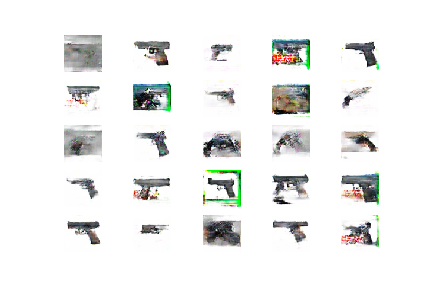

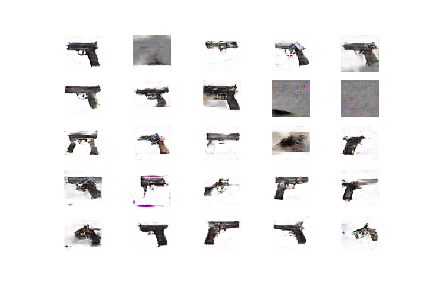

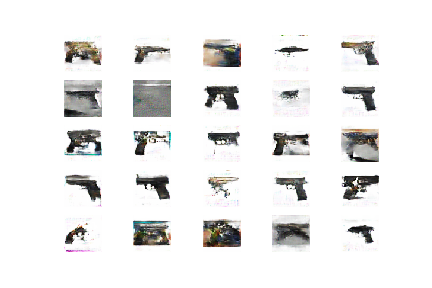

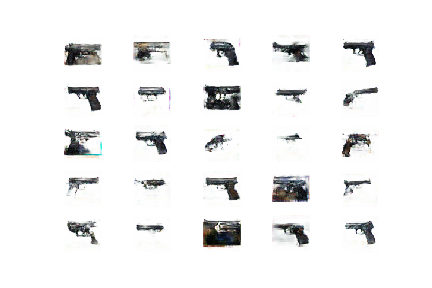

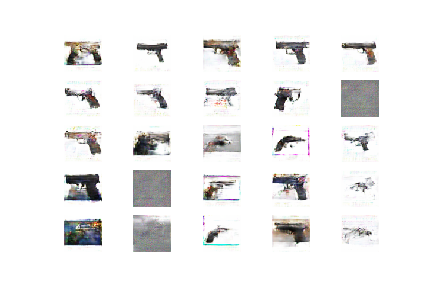

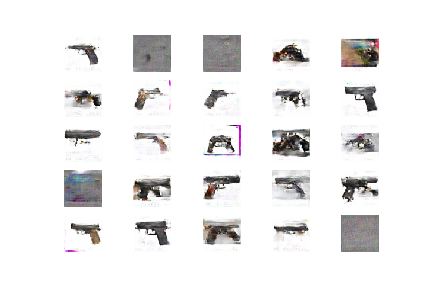

In [0]:
from IPython.display import Image 
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_7000.png')
display(pil_img)
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_8000.png')
display(pil_img)
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_9000.png')
display(pil_img)
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_9300.png')
display(pil_img)
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_9500.png')
display(pil_img)
pil_img = Image(filename='drive/My Drive/EVA/Session Assignments/GAN/guns_9900.png')
display(pil_img)